In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

from tqdm import tqdm
from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
DATA_PATH = '/kaggle/input/march-machine-learning-mania-2024/'
start_year = 2016

In [2]:
answers = pd.read_csv('/kaggle/input/starter-notebook-exact-scores-from-2023/submission.csv')
answers_man = answers[answers['Tournament'] == 'M']
answers_woman = answers[answers['Tournament'] == 'W'].reset_index(drop=True)

In [3]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
df_seeds_2023 = df_seeds[df_seeds['Season'] == 2023]
df_seeds_2023

,Season,Seed,TeamID
2422,2023,W01,1345
2423,2023,W02,1266
2424,2023,W03,1243
2425,2023,W04,1397
2426,2023,W05,1181
...,...,...,...
4161,2023,Z12,3405
4162,2023,Z13,3387
4163,2023,Z14,3241
4164,2023,Z15,3436


In [4]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [7]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [8]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [9]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [10]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [11]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [12]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True)  

In [13]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [14]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)
df_features_season

,Season,TeamID,WinRatio,GapAvg
0,1985,1102,0.208333,-5.791667
1,1985,1103,0.391304,-3.043478
2,1985,1104,0.700000,7.800000
3,1985,1106,0.416667,-3.791667
4,1985,1108,0.760000,7.960000
...,...,...,...,...
22145,2024,3474,0.153846,-14.461538
22146,2024,3475,0.785714,7.571429
22147,2024,3476,0.133333,-16.766667
22148,2024,3477,0.448276,-6.551724


In [15]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [16]:
df = df_tourney_results.copy()
df = df[df['Season'] >= start_year].reset_index(drop=True)

In [17]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})


In [18]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [19]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [20]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [21]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [22]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [23]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [24]:
df = add_loosing_matches(df)

In [25]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [26]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)
# df = df[df['TeamIdA'].isin(df_seeds_2023['TeamID']) | df['TeamIdB'].isin(df_seeds_2023['TeamID'])].reset_index(drop=True)

In [27]:
#df_test = df[df['Season'] == 2023].copy() 
df = df[df['Season'] != 2023].copy() 
#df_test.drop('WinA', axis=1, inplace=True)

In [28]:
df_test = pd.read_csv("/kaggle/input/paris-madness-2023/submission.csv")
df_test['Pred'] = 0.5
print(df_test)
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

                    ID  Pred
0       2023_1101_1102   0.5
1       2023_1101_1103   0.5
2       2023_1101_1104   0.5
3       2023_1101_1105   0.5
4       2023_1101_1106   0.5
...                ...   ...
130678  2023_3474_3476   0.5
130679  2023_3474_3477   0.5
130680  2023_3475_3476   0.5
130681  2023_3475_3477   0.5
130682  2023_3476_3477   0.5

[130683 rows x 2 columns]


In [29]:
round_slots = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2023]
round_slots = round_slots[round_slots['Slot'].str.contains('R')]
                          
seeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M']
seeds_w = seeds[seeds['Tournament'] == 'W']
preds = pd.read_csv('/kaggle/input/paris-madness-2023/submission.csv') 
preds['ID'] = preds['ID'].str.split('_')

In [30]:
features = [
    "SeedA", "SeedB", 'WinRatioA', 'WinRatioB', 'GapAvgA', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]
# features = [
#     'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
# ]

## Bracket simulation  <a class="anchor"  id="chapter2"></a>

In [31]:
def prepare_data(seeds, preds):
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, sim=True):
    winners = []
    slots = []

    for slot, strong, weak in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed):
        team_1, team_2 = seeds[strong], seeds[weak]
        proba = probas[str(team_1)][str(team_2)]
            
        if sim:
            winner = np.random.choice([team_1, team_2], p=[proba, 1 - proba])
        else:
            winner = [team_1, team_2][np.argmax([proba, 1-proba])]

        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    results = []
    bracket = []
    slots = []

    for b in tqdm(range(1, brackets+1)):
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, sim)
        
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

  ## Get score by submission  <a class="anchor"  id="subsection1"></a>

In [32]:
def get_score(submission, answers_man, answers_woman, verbose=0):
    score_gen = []
    score_man = []
    for i in range(n_brackets):
        submission_temp = submission.iloc[i*63:(i+1)*63].reset_index(drop=True)
        submission_temp['Right'] = (submission_temp['Team'] == answers_man['Team'])
        submission_temp['Score'] = 2 ** submission_temp['Slot'].str[1].astype(int) * submission_temp['Right'] / 2
        score_man.append(submission_temp['Score'].sum() / 2)
    score_woman = []
    for i in range(n_brackets):
        submission_temp = submission.iloc[n_brackets*63+i*63:n_brackets*63+(i+1)*63].reset_index(drop=True)
        submission_temp['Right'] = (submission_temp['Team'] == answers_woman['Team'])
        submission_temp['Score'] = 2 ** submission_temp['Slot'].str[1].astype(int) * submission_temp['Right'] / 2
        score_woman.append(submission_temp['Score'].sum() / 2)
    if verbose:
        print(score_man, score_woman)
        print(sum(score_man)/n_brackets,  sum(score_woman)/n_brackets)
    print(sum(score_man)/n_brackets + sum(score_woman)/n_brackets)
    return score_man, score_woman, sum(score_man)/n_brackets + sum(score_woman)/n_brackets

  ## AI <a class="anchor"  id="subsection1"></a>

In [33]:
def rescale(features, df_train, df_val, df_test=None, scaling=True):
    if scaling:
        min_ = df_train[features].min()
        max_ = df_train[features].max()

        df_train[features] = (df_train[features] - min_) / (max_ - min_)
        df_val[features] = (df_val[features] - min_) / (max_ - min_)

        if df_test is not None:
            df_test[features] = (df_test[features] - min_) / (max_ - min_)
    
    return df_train, df_val, df_test

In [34]:
def kfold(df, df_test_=None, plot=False, verbose=0, scaling=True, mode="reg"):
    seasons = np.sort(df['Season'].unique())
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        if scaling:
            df_train, df_val, df_test = rescale(features, df_train, df_val, df_test, scaling=True)
        else:
            df_train, df_val, df_test = rescale(features, df_train, df_val, df_test, scaling=False)
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)
            
        model.fit(df_train[features], df_train[target])

        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
          

            
        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\nValidating on season {season}')
            print(f'\t -> Scored {score:.3f}')
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    

    pred_test = np.round(model.predict_proba(df_test[features])[:, 1])
    pred_test = model.predict_proba(df_test[features])[:, 1]
    print(model.coef_)
    print(features)
    return pred_test

In [35]:
pred_test = kfold(df, df_test, plot=False, verbose=0, scaling=1, mode="LogisticRegression")
preds['Pred'] = pred_test
df_test['Pred'] = pred_test
preds


 Local CV is 0.178
[[-1.60482817  1.60486469 -0.47339224  0.47395809  1.47658238 -1.47721785
  -1.60475746 -0.5805451   1.81203083]]
['SeedA', 'SeedB', 'WinRatioA', 'WinRatioB', 'GapAvgA', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff']


,ID,Pred
0,"[2023, 1101, 1102]",0.480424
1,"[2023, 1101, 1103]",0.467601
2,"[2023, 1101, 1104]",0.427698
3,"[2023, 1101, 1105]",0.510149
4,"[2023, 1101, 1106]",0.552332
...,...,...
130678,"[2023, 3474, 3476]",0.411557
130679,"[2023, 3474, 3477]",0.436021
130680,"[2023, 3475, 3476]",0.519158
130681,"[2023, 3475, 3477]",0.544103


100%|██████████| 1000/1000 [00:01<00:00, 738.04it/s]


39.5145


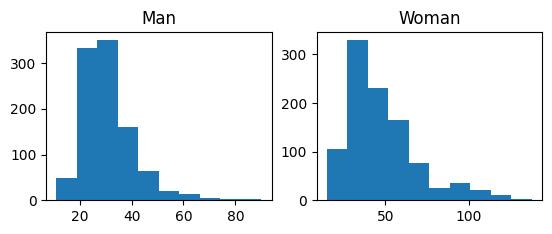

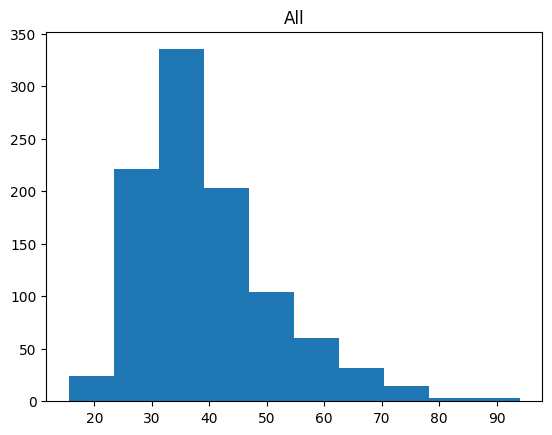

In [36]:
n_brackets = 1000
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=True)
result_w['Tournament'] = 'W'
# result_w = pd.read_csv('/kaggle/input/starter-notebook-exact-scores-from-2023/submission.csv')
# result_w = result_w[result_w['Tournament'] == 'W'].drop('RowId', axis=1)
submission = pd.concat([result_m, result_w])
submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']
submission = submission[['Tournament', 'Bracket', 'Slot', 'Team']]
score_man, score_woman, _ = get_score(submission, answers_man, answers_woman, verbose=0)
score_man = [x * 2 for x in score_man]
score_woman = [x * 2 for x in score_woman]
plt.subplot(2, 2, 1)
plt.title('Man')
plt.hist(score_man)
plt.subplot(2, 2, 2)
plt.title('Woman')
plt.hist(score_woman)
plt.show()
plt.title('All')
plt.hist([(x + y)/2 for x, y in zip(score_man, score_woman)])
plt.show()

In [37]:
n_brackets = 1
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=False)
result_m['Tournament'] = 'M'
result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=False)
result_w['Tournament'] = 'W'
submission = pd.concat([result_m, result_w])
submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']
submission = submission[['Tournament', 'Bracket', 'Slot', 'Team']]
submission.to_csv('submission.csv')
pd.set_option('display.max_rows', 1000)
submission

100%|██████████| 1/1 [00:00<00:00, 650.38it/s]


,Tournament,Bracket,Slot,Team
RowId,,,,
0,M,1,R1W1,W16
1,M,1,R1W2,W15
2,M,1,R1W3,W14
3,M,1,R1W4,W13
4,M,1,R1W5,W12
5,M,1,R1W6,W06
6,M,1,R1W7,W07
7,M,1,R1W8,W09
8,M,1,R1X1,X01
